# Apply GraphVelo to human cortex multi-omics dataset

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from graphvelo.mo import gen_wnn
from graphvelo.graph_velocity import GraphVelo

### Load data file and LSI embedding calculated by SCARlink

In [3]:
cell_info_file = "../../../data/human_cortex/cell_info.txt"
lsi_file = "../../../data/human_cortex/scatac_LSI.csv"
mv_rna_file = "../../../data/human_cortex/human_brain_rna_after_filt_r2.h5ad"
mv_atac_file = "../../../data/human_cortex/human_brain_atac_gene_after_filt_r2.h5ad"
X_lsi = pd.read_csv(lsi_file, sep='\t').values
cell_info = pd.read_csv(cell_info_file, sep="\t")
cell_info.index = cell_info['cell_name'].str.replace('#', '_').str.replace('-1', '')

In [4]:
adata = sc.read(mv_rna_file)
adata_atac = sc.read(mv_atac_file)
shared_cells = adata.obs_names.intersection(cell_info.index)
adata = adata[shared_cells]
adata_atac = adata_atac[shared_cells]

In [5]:
idx = [cell_info.index.get_loc(i) for i in adata.obs_names]
X_lsi = X_lsi[idx]
adata.obsm['X_lsi'] = X_lsi

In [6]:
adata = gen_wnn(adata, copy=True, k=50)

0 out of 4602 0.00 seconds elapsed
2000 out of 4602 3.86 seconds elapsed
4000 out of 4602 7.63 seconds elapsed


In [ ]:
# adata.write('adata_wnn_k50.h5ad') # adata_wnn_ SCARlink lsi

In [ ]:
# adata = sc.read('adata_wnn_k50.h5ad')

### Use nearset neighobrs calculated by WNN as unified manifold approximation. 

In [7]:
adata.uns['neighbors'] = adata.uns['WNN'].copy()
adata.obsp['connectivities'] = adata.obsp['WNN'].copy()
adata.obsp['distances'] = adata.obsp['WNN_distance'].copy()

In [8]:
adata.layers['Mc'] = adata.obsp['WNN'] @ adata_atac.X

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 10/10 cores)


  0%|          | 0/483 [00:00<?, ?gene/s]

    finished (0:00:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/10 cores)


  0%|          | 0/4602 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


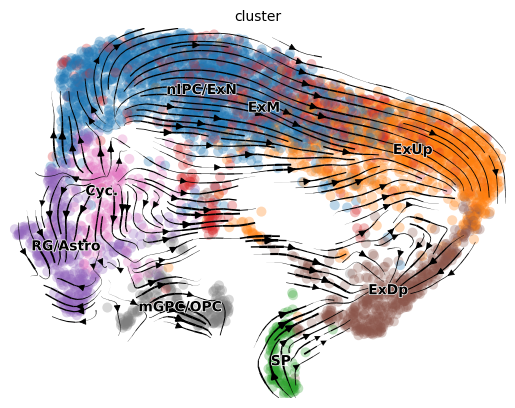

In [9]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata, n_jobs=-1)
scv.tl.latent_time(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['cluster'])

In [10]:
gv = GraphVelo(adata, xkey='Ms', vkey='velocity')
gv.train()
adata.layers['velocity_gv'] = gv.project_velocity(adata.layers['Ms'])
adata.layers['velocity_c'] = gv.project_velocity(adata.layers['Mc'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_umap'] = gv.project_velocity(adata.obsm['X_umap'])

Learning Phi in tangent space projection.: 100%|██████████| 4602/4602 [00:04<00:00, 1100.79it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 4602/4602 [00:00<00:00, 9204.94it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 4602/4602 [00:00<00:00, 8003.50it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 4602/4602 [00:00<00:00, 22548.86it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 4602/4602 [00:00<00:00, 19287.18it/s]


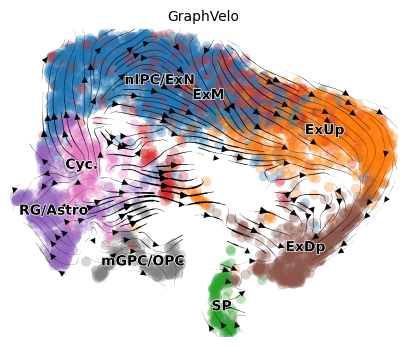

In [11]:
ax = scv.pl.velocity_embedding_stream(adata, color=['cluster'], basis='umap', X=adata.obsm['X_umap'], V=adata.obsm['gv_umap'], title='GraphVelo', figsize=(5, 4), show=False)
# plt.savefig("figures/human_cortex_vf.svg", dpi=300, transparent=True)
plt.show()

In [ ]:
import scipy.sparse as sp
sp.save_npz('gv_result_k50.npz', gv.T)
adata.write('gv_result_k50.h5ad')